## Задача

Научите нейросеть читать номера домов по этому датасету http://ufldl.stanford.edu/housenumbers/. В качестве меток можно использовать сами цифры и их порядок, но не bounding boxes.

## Meta

Решения, какие этапы и как именно делать, принимались исходя из:
    - минимизации затрат времени
    - ограниченности выч. ресурсов (под рукой только CPU и хреновый интернет)
    
**Итоговая метрика: среднее accuracy для 5 предсказанных цифр (mean_acc) на тестовом датасете**
    

## Ход решения
1. Исследование задачи: делалось ли что-нибудь похожее:
    - а. алгоритм поиска ROI (MSER) + классификатор https://github.com/penny4860/SVHN-deep-digit-detector
    - б. **многоголовый классификатор** (статья https://arxiv.org/pdf/1312.6082 + совр. реализация https://github.com/potterhsu/SVHNClassifier-PyTorch)
2. Датасет -> lmdb (более удобный формат)
3. EDA для датасета:
    - "глазной анализ"
    - распределение количества цифр
    - распределение цифр 
    - TODO: в какой позиции какие цифры встречаются
    - TODO: сравнение train и test на похожесть
4. Построение модели
    - выбор архитектуры
    - TODO: подбор гиперпараметров (LR, количество эпох)
    - обучение
    - подсчёт метрик
5. TODO: повторить 4 для разных вариантов
6. TODO: анализ ошибок
7. Предложения по улучшению результата
    - не все позиции цифр одинаково важны - можно сообщить об этом модели
    - добавить длину числа как выход модели 
    - побороться с разбалансированностью (голова0 никогда не видит 10, голова4 почти ничего не видит кроме 10)
    - добавить предобучение одиночного классификатора на MNIST или том же SVHN (формат 2 исх. данных)
    - побороться с оверфиттингом (регуляризация, аугментации, dropout)
    
## Результаты

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc_0</th>
      <th>acc_1</th>
      <th>acc_2</th>
      <th>acc_3</th>
      <th>acc_4</th>
      <th>mean_acc</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>mobnet_8x8_finetune_no_freeze</th>
      <td>0.367647</td>
      <td>0.240809</td>
      <td>0.832338</td>
      <td>0.988664</td>
      <td>0.999847</td>
      <td>0.685861</td>
    </tr>
    <tr>
      <th>mobnet_8x8_finetune_freeze</th>
      <td>0.050475</td>
      <td>0.082721</td>
      <td>0.018689</td>
      <td>0.988664</td>
      <td>0.999847</td>
      <td>0.428079</td>
    </tr>
  </tbody>
</table>

1. mobnet_8x8_finetune_no_freeze = взяли MobileNetV2, предобученный на ImageNet, отрезали часть слоёв, добавили 5 новых голов (для 5 возможных позиций цифры в числе), обучили 5 эпох
2. mobnet_8x8_finetune_freeze - то же самое, но оригинальные слои заморожены (т.е. учатся только головы)

In [1]:
import os
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam

%load_ext autoreload
%autoreload 2
from dataset import Dataset

Using TensorFlow backend.


# convert and load data

In [2]:
#!python3 convert_to_lmdb.py

In [2]:
test_ds = Dataset('data/test.lmdb')
train_ds = Dataset('data/train.lmdb')
print(len(test_ds), len(train_ds))

13068 33401


# eda

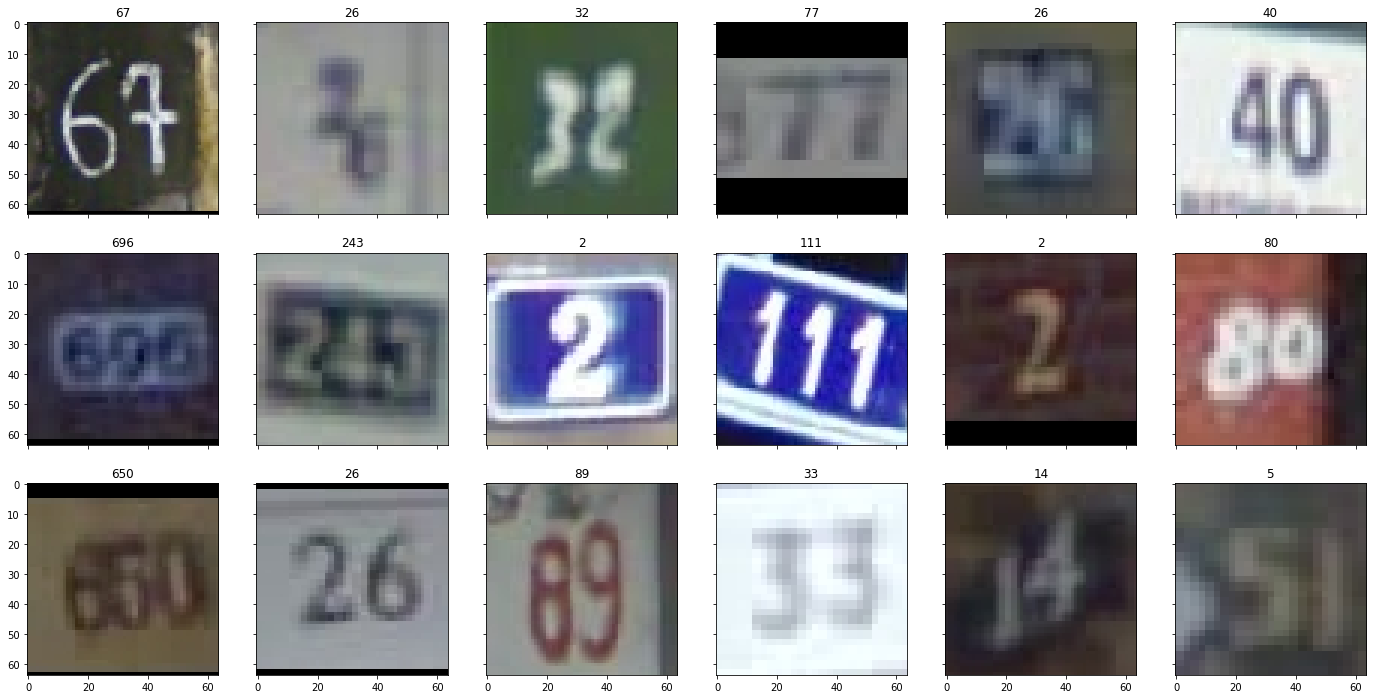

In [4]:
def plot_imgs(ds, r, c, cell_size=4, seed=None):
    _, ax = plt.subplots(r, c, sharex=True, sharey=True, figsize=(c * cell_size, r * cell_size))
    idxs = np.random.RandomState(seed).choice(range(len(ds)), r * c)
    for idx, ax in zip(idxs, ax.flatten()):
        im, length, digits = ds[idx]
        ax.imshow(im)
        ax.set_title("".join(str(d) for d in digits if d != 10))

plot_imgs(test_ds, 3, 6)

In [5]:
print('train images:' , set([train_ds[i][0].size for i in range(len(test_ds))]))
print('test images:' , set([test_ds[i][0].size for i in range(len(test_ds))]))

train images: {(64, 64)}
test images: {(64, 64)}


In [7]:
digit_counter = Counter()
lengths = []
for _, length, digits in train_ds:
    lengths.append(length)
    digit_counter.update([d for d in digits if d != 10])

Counter({2: 18130, 3: 8691, 1: 5137, 4: 1434, 5: 9})


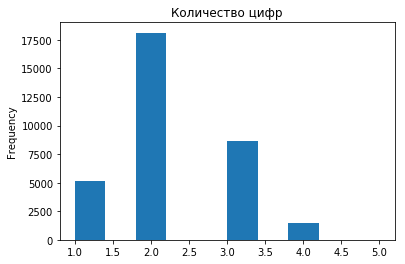

In [8]:
ser_len = pd.Series(lengths)
ser_len.plot.hist(title='Количество цифр')
print(Counter(lengths))

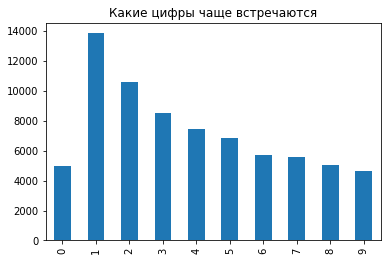

In [9]:
pd.Series(digit_counter).sort_index().plot.bar(title="Какие цифры чаще встречаются")

# model

In [8]:
input_height, input_width, n_channels = 64, 64, 3
classes = ['%d' % i for i in range(11)]
num_classes = len(classes)
print(classes, num_classes)

def load_mobilenet(load_weights=True):
    model = MobileNetV2(input_shape=(input_height, input_width, n_channels), 
                    alpha=1.0, depth_multiplier=1, include_top=True, 
                    weights=None, #'imagenet', 
                    classes=num_classes)
    model.layers.pop()
    if load_weights:
        model.load_weights('models/weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
    return model

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'] 11


In [92]:
model = load_mobilenet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [76]:
print(model.layers[54].name)

block_5_add


In [6]:
def modify_model(model, layers_to_pop, layers_to_freeze=0):
    for l in model.layers[:layers_to_freeze]:
        l.trainable = False
    for _ in range(layers_to_pop):
        model.layers.pop()
    flat = Flatten()(model.layers[-1].output)
    digits = [Dense(num_classes, activation='softmax', name='digit_%d' % i)(flat) 
              for i in range(5)]
    res =  Model(inputs=model.inputs, outputs=digits)
    res.compile(optimizer='adam', loss={'digit_%d' % i: 'categorical_crossentropy' for i in range(5)},
              metrics=['accuracy'])
    return res

In [93]:
new_model = modify_model(model, 101, 54)
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

# generator

In [80]:
def batch_generator(ds, batch_size, is_train):
    idx = 0
    while True:
        X_batch = np.zeros((batch_size, input_height, input_width, n_channels), dtype='float32')
        ys = {'digit_%d' % i: np.zeros((batch_size, num_classes), dtype='float32') 
              for i in range(5)}

        # fill up the batch
        for row in range(batch_size):
            im, length, digits = ds[idx]
            X_batch[row] = preprocess_input(np.array(im) / 255.)
            for i, digit in enumerate(digits):
                ys['digit_%d' % i][row, classes.index(str(digit))] = 1
            idx += 1
            idx = idx % len(ds)
        yield(X_batch, ys)
        
gen = batch_generator(train_ds, 8, True)
for b in gen:
    print(b[0].shape, b[1].keys())
    break

(8, 64, 64, 3) dict_keys(['digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4'])


# train

In [82]:
hist = new_model.fit_generator(batch_generator(train_ds, 64, is_train=1), 
                    steps_per_epoch=100,
                    validation_data=batch_generator(test_ds, 64, is_train=1),
                    validation_steps=100, 
                    epochs=5, 
                    verbose=1)

Epoch 1/5
100/100 [==============================] - 58s 578ms/step - loss: 14.0500 - digit_0_loss: 3.4439 - digit_1_loss: 5.1533 - digit_2_loss: 4.2106 - digit_3_loss: 0.9702 - digit_4_loss: 0.2719 - digit_0_acc: 0.4398 - digit_1_acc: 0.3392 - digit_2_acc: 0.6766 - digit_3_acc: 0.9313 - digit_4_acc: 0.9761 - val_loss: 26.2418 - val_digit_0_loss: 10.7302 - val_digit_1_loss: 8.0284 - val_digit_2_loss: 7.2333 - val_digit_3_loss: 0.1775 - val_digit_4_loss: 0.0724 - val_digit_0_acc: 0.0481 - val_digit_1_acc: 0.1130 - val_digit_2_acc: 0.0192 - val_digit_3_acc: 0.9889 - val_digit_4_acc: 0.9998
Epoch 2/5
100/100 [==============================] - 55s 548ms/step - loss: 10.3542 - digit_0_loss: 2.0626 - digit_1_loss: 3.7474 - digit_2_loss: 3.8164 - digit_3_loss: 0.7203 - digit_4_loss: 0.0076 - digit_0_acc: 0.5852 - digit_1_acc: 0.4619 - digit_2_acc: 0.7100 - digit_3_acc: 0.9553 - digit_4_acc: 0.9995 - val_loss: 21.6028 - val_digit_0_loss: 7.4477 - val_digit_1_loss: 7.2897 - val_digit_2_loss: 6.

In [85]:
def get_mean_hist_acc(hist, is_val=False):
    start_pattern = 'val_' if is_val else '' 
    start_pattern += 'digit'
    return np.array([v for k, v in hist.history.items() if k.startswith(start_pattern) and k.endswith('acc')]).mean(axis=0)
print(get_mean_hist_acc(hist))
print(get_mean_hist_acc(hist, is_val=True))

[0.67259375 0.742375   0.77153125 0.77659375 0.784     ]
[0.4338125  0.45803125 0.4461875  0.428125   0.428625  ]


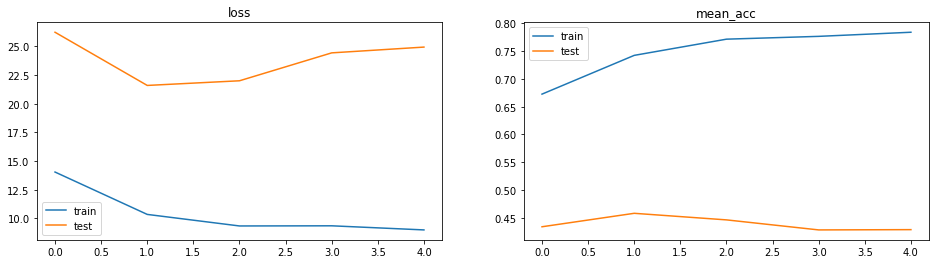

In [86]:
def plot_hist(hist):
    _, ax = plt.subplots(1, 2, figsize=(16, 4))

    ax[0].plot(hist.history['loss'], label='train')
    ax[0].plot(hist.history['val_loss'], label='test')
    ax[0].legend()
    ax[0].set_title('loss')
    
    ax[1].plot(get_mean_hist_acc(hist), label='train')
    ax[1].plot(get_mean_hist_acc(hist, is_val=True), label='test')
    ax[1].legend()
    ax[1].set_title('mean_acc')
    
plot_hist(hist)

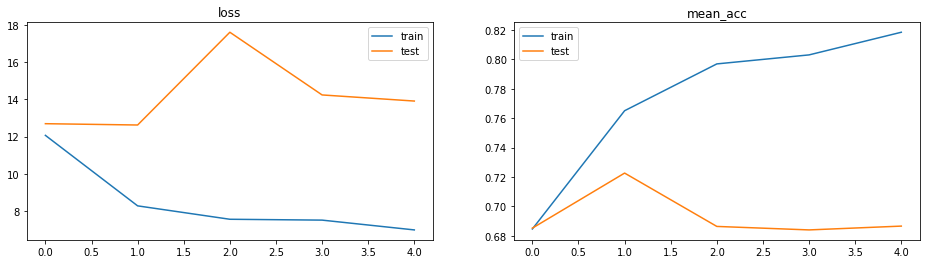

In [44]:
#

In [84]:
new_model.save_weights('models/weights/finetune_freeze_8x8_ep5.h5')

# evaluate

In [3]:
def load_model(fpath):
    res = load_mobilenet(load_weights=False)
    res = modify_model(res, 101)
    res.load_weights(fpath)
    return res

In [94]:
model_names = ['mobnet_8x8_finetune_no_freeze',
               'mobnet_8x8_finetune_freeze']
model_fpath = ['models/weights/finetune_no_freeze_8x8_ep5.h5',
               'models/weights/finetune_freeze_8x8_ep5.h5']
models = [load_model(fpath) for fpath in model_fpath]

In [95]:
results = [m.evaluate_generator(batch_generator(test_ds, 64, is_train=1), steps=len(test_ds) // 64)
           for m in models]
print(results)

[[13.977310320910286, 5.007789609478969, 6.411050235523897, 2.373290065456839, 0.18271134983675152, 0.0024691899033153757, 0.36764705882352944, 0.24080882352941177, 0.8323376225490197, 0.9886642156862745, 0.9998468137254902], [24.92350227692548, 8.912670158872418, 9.263681194361519, 6.492912026012645, 0.18076372276394906, 0.07347526855985909, 0.05047487745098039, 0.08272058823529412, 0.018688725490196078, 0.9886642156862745, 0.9998468137254902]]


In [96]:
df = pd.DataFrame([r[-5:] for r in results], 
                  columns=['acc_%d' % i for i in range(5)],
                  index=model_names)
df['mean_acc'] = df.iloc[:, :5].mean(axis=1)
df.to_csv('results.csv')
df

,acc_0,acc_1,acc_2,acc_3,acc_4,mean_acc
mobnet_8x8_finetune_no_freeze,0.367647,0.240809,0.832338,0.988664,0.999847,0.685861
mobnet_8x8_finetune_freeze,0.050475,0.082721,0.018689,0.988664,0.999847,0.428079


In [98]:
print(df.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc_0</th>
      <th>acc_1</th>
      <th>acc_2</th>
      <th>acc_3</th>
      <th>acc_4</th>
      <th>mean_acc</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>mobnet_8x8_finetune_no_freeze</th>
      <td>0.367647</td>
      <td>0.240809</td>
      <td>0.832338</td>
      <td>0.988664</td>
      <td>0.999847</td>
      <td>0.685861</td>
    </tr>
    <tr>
      <th>mobnet_8x8_finetune_freeze</th>
      <td>0.050475</td>
      <td>0.082721</td>
      <td>0.018689</td>
      <td>0.988664</td>
      <td>0.999847</td>
      <td>0.428079</td>
    </tr>
  </tbody>
</table>


# some predictions

In [33]:
best_model = load_model('models/weights/finetune_no_freeze_8x8_ep5.h5')

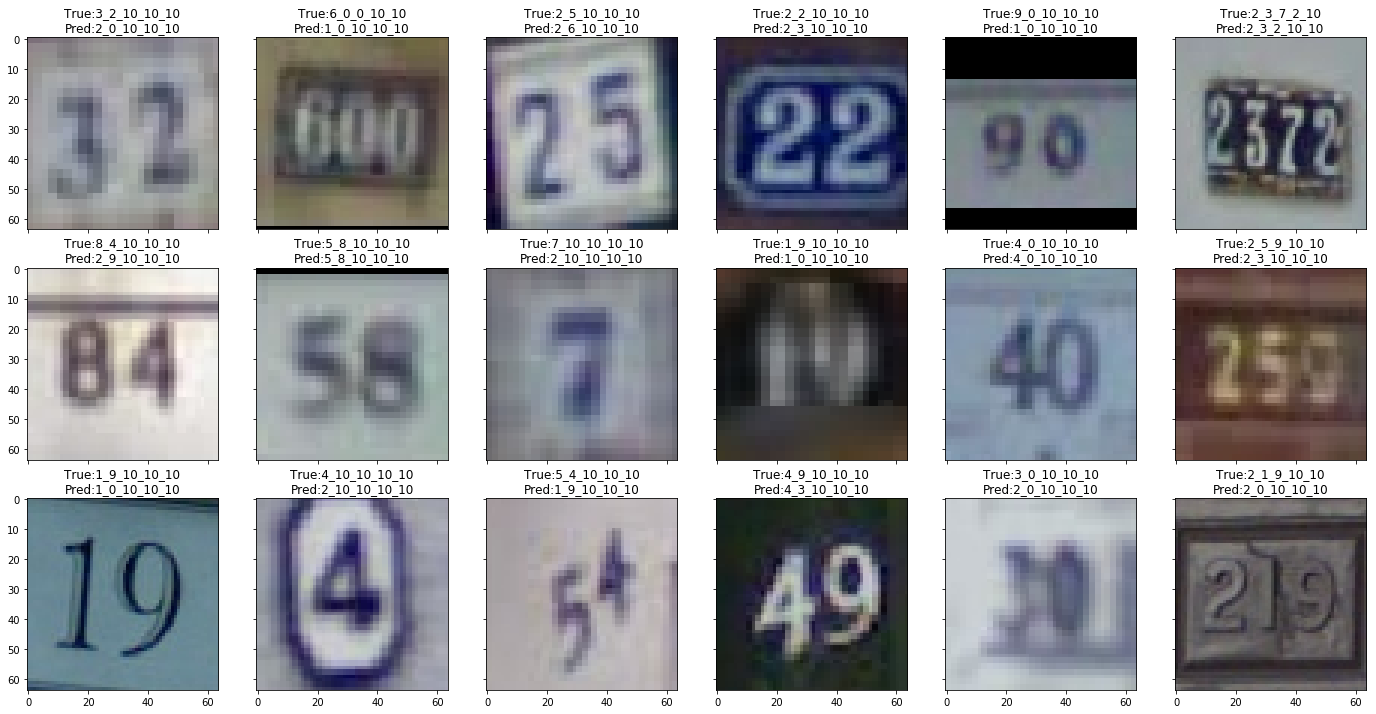

In [34]:
def plot_preds(model, ds, r, c, cell_size=4, seed=None):
    _, ax = plt.subplots(r, c, sharex=True, sharey=True, figsize=(c * cell_size, r * cell_size))
    idxs = np.random.RandomState(seed).choice(range(len(ds)), r * c)
    for idx, ax in zip(idxs, ax.flatten()):
        im, length, digits = ds[idx]
        ax.imshow(im)
        true_label = 'True:' + "_".join([str(d) for d in digits])
        
        pred = best_model.predict(np.array([preprocess_input(np.array(im) / 255.)]))
        pred_label = 'Pred:' + "_".join([classes[d.argmax()] for d in pred])
        ax.set_title(true_label + '\n' + pred_label)

plot_preds(best_model, test_ds, 3, 6)